In [ ]:
# default_exp train

# train.py

> training model

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from baseline_3d_pose.utils import *
from baseline_3d_pose.model import *
from baseline_3d_pose.dataset import *
from baseline_3d_pose.viz import *
from fastai.vision import *
from fastprogress.fastprogress import master_bar, progress_bar
import json
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.gridspec import GridSpec

In [ ]:
# export
class Options():
    def __init__(self):
        # paths
        self.data_path = Path('data')
        self.model_path = Path('model')
        
        # train options
        self.actions = 'All'
        self.attempt_id = '01'
        self.attempt_path = Path('model')/self.attempt_id
        
        self.load_ckpt = False
        
        # train hyper-params
        self.bs = 128
        self.epochs = 10
        self.lr = 1e-3
        
        # model hyper-params
        self.size = 1024
        self.stages = 2
        self.dropout = 0.5

In [ ]:
# export
def save_options(options):
    options.attempt_path.mkdir(exist_ok=True)
    torch.save(options, options.attempt_path/'options.pt')

In [ ]:
# export
def save_ckpt(model_state, optimizer_state, options, is_best=False):
    options.attempt_path.mkdir(exist_ok=True)
    model_name = 'best_model.pt' if is_best else 'last_model.pt'
    optimizer_name = 'best_optimizer.pt' if is_best else 'last_optimizer.pt'
    torch.save(model_state, options.attempt_path/model_name)
    torch.save(optimizer_state, options.attempt_path/optimizer_name)

In [ ]:
# export
options = Options()

In [ ]:
# export
stat_3d = torch.load(data_path/'stat_3d.pt')
stat_2d = torch.load(data_path/'stat_2d.pt')
rcams = torch.load(data_path/'rcams.pt')

mean_2d = stat_2d['mean']
std_2d = stat_2d['std']
dim_use_2d = stat_2d['dim_use']
dim_ignore_2d = stat_2d['dim_ignore']

mean_3d = stat_3d['mean']
std_3d = stat_3d['std']
dim_use_3d = stat_3d['dim_use']
dim_ignore_3d = stat_3d['dim_ignore']

In [ ]:
# export
def train(train_dl, model, criterion, optimizer, options, mb):
    model.train()
    loss_list = []
    skel_loss_list = []
    for xb, yb in progress_bar(train_dl, parent=mb):
        xb, yb = xb.cuda(), yb.cuda()
        yhat = model(xb)
        optimizer.zero_grad()
        loss_skel = criterion(yhat, yb)
        loss = loss_skel.mean()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        loss_list.append(loss.item())
        skel_loss_list.append(loss_skel.data.cpu().numpy())
        
        mb.child.comment = f'train loss: {loss.item()}'
    return loss_list, skel_loss_list

In [ ]:
# export
def test(test_dl, model, criterion, options, mb):
    model.eval()
    loss_list = []
    skel_loss_list = []
    for xb, yb in progress_bar(test_dl, parent=mb):
        xb, yb = xb.cuda(), yb.cuda()
        with torch.no_grad():
            yhat = model(xb)
            loss_skel = criterion(yhat, yb)
            loss = loss_skel.mean()
        loss_list.append(loss.item())
        skel_loss_list.append(loss_skel.data.cpu().numpy())
        mb.child.comment = f'test loss: {loss.item()}'
    return loss_list, skel_loss_list

In [ ]:
# export
model = Model()
model = model.cuda()
model.apply(init_kaiming)
print(f'total params: {sum(p.numel() for p in model.parameters())}')

criterion = nn.MSELoss(reduction='none').cuda()
optimizer = optim.Adam(model.parameters(), lr=options.lr)

if options.load_ckpt:
    options = torch.load('model/01/options.pt')
    model_state = torch.load(options.attempt_path/'last_model.pt')
    optimizer_state = torch.load(options.attempt_path/'last_optimizer.pt')
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)

total params: 4291632


In [ ]:
# export
train_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=True)
train_dl = DataLoader(train_ds, batch_size=options.bs, shuffle=True)
test_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=False)
test_dl = DataLoader(test_ds, batch_size=options.bs, shuffle=False)

In [ ]:
# mb = master_bar(range(options.epochs))
# for epoch in mb:
#     train_loss_list, train_skel_loss_list = train(train_dl, model, criterion, optimizer, options, mb)
#     test_loss_list, test_skel_loss_list = test(test_dl, model, criterion, options, mb)
#     torch.save(train_loss_list, options.attempt_path/f'train_loss_list_e{epoch}.pt')
#     torch.save(train_skel_loss_list, options.attempt_path/f'train_skel_loss_list_e{epoch}.pt')
#     torch.save(test_loss_list, options.attempt_path/f'test_loss_list_e{epoch}.pt')
#     torch.save(test_skel_loss_list, options.attempt_path/f'test_skel_loss_list_e{epoch}.pt')
#     mb.main_bar.comment = f'train loss_mean: {np.mean(train_loss_list)} | test loss_mean: {np.mean(test_loss_list)}'
#     optimizer.param_groups[0]['lr'] *= 0.5

# # save_options(options)
# # save_ckpt(model.state_dict(), optimizer.state_dict(), options)

In [ ]:
# export
options = torch.load('model\\01\\options.pt')
model_state = torch.load(options.attempt_path/'last_model.pt')
optimizer_state = torch.load(options.attempt_path/'last_optimizer.pt')

model.load_state_dict(model_state)
optimizer.load_state_dict(optimizer_state)

NotImplementedError: cannot instantiate 'PosixPath' on your system

In [ ]:
# export
model.eval()

Model(
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.5, inplace=False)
  (ln_in): Linear(in_features=32, out_features=1024, bias=True)
  (bn_in): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lins): ModuleList(
    (0): ResLinear(
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (ln1): Linear(in_features=1024, out_features=1024, bias=True)
      (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln3): Linear(in_features=1024, out_features=1024, bias=True)
      (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResLinear(
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (ln1): Linear(in_features=1024, out_features=1024, bias=True)
      (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln3): Linear(in_features=1024, out_features=1024,

In [ ]:
# train_loss_lists = []
# for i in range(options.epochs):
#     tll = torch.load(options.attempt_path/f'train_loss_list_e{i}.pt')
#     print(np.mean(tll))
#     train_loss_lists.append(tll)

0.14970600270755904
0.07525452856667157
0.06601756414187311
0.06194997761424844
0.06021508343833265
0.059299225053352105
0.05879475238269701
0.058564195222938646
0.05842938672781147
0.05839051824199406


In [ ]:
# test_loss_lists = []
# for i in range(options.epochs):
#     tll = torch.load(options.attempt_path/f'test_loss_list_e{i}.pt')
#     print(np.mean(tll))
#     test_loss_lists.append(tll)

0.05828409053074384
0.04996376345518618
0.046002125642892376
0.04507989156536623
0.043278035388022024
0.04382986145055936
0.04366219976634612
0.04271084520496473
0.043402563580296684
0.043738594483488914


In [ ]:
train_lls = np.hstack(train_loss_lists)
test_lls = np.hstack(test_loss_lists)

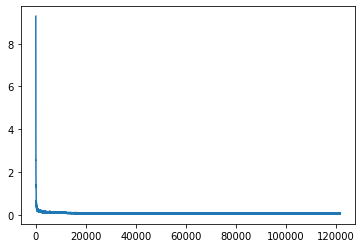

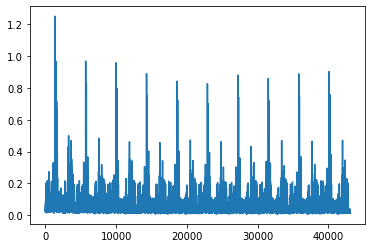

In [ ]:
# plt.plot(train_lls)
# plt.show()
# plt.plot(test_lls)
# plt.show()

In [ ]:
# export
json_path = Path('json')

In [ ]:
# export
kp = get_kp_from_json(json_path/'kp2.json')
kps = coco_to_skel(kp)

FileNotFoundError: [Errno 2] No such file or directory: 'json\\kp2.json'

In [ ]:
# export
kps_norm = normalize_kp(kps, mean_2d, std_2d, dim_use_2d)
kps_unnorm = unnormalize_data(kps_norm, mean_2d, std_2d, dim_ignore_2d)

In [ ]:
# export
kps_tnsr = torch.from_numpy(kps_norm).float()
kps_tnsr_3d = model(kps_tnsr.cuda())

kps_3d = kps_tnsr_3d.cpu().detach().numpy()
key = train_ds.get_key(0)
kps_3d = unnormalize_data(kps_3d, mean_3d, std_3d, dim_ignore_3d)
kps_3d = cam_to_world_centered(kps_3d, key, rcams)

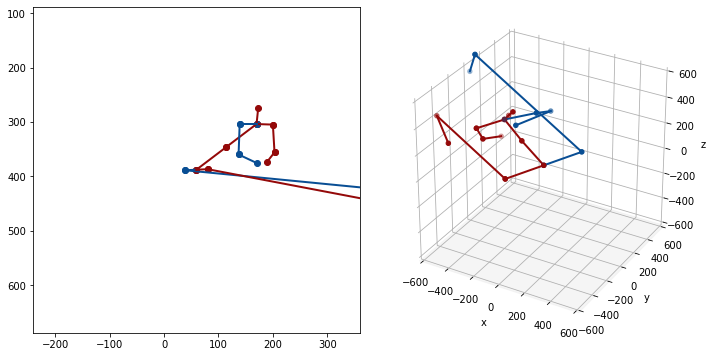

In [ ]:
# export
plt.figure(figsize=(12,6))
gs = GridSpec(1,2)
gs.update(wspace=0.05, hspace=0.05)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], projection='3d')

show_2d_pose(kps_unnorm, ax)
ax.invert_yaxis()

show_3d_pose(kps_3d, ax2)

plt.show()